## Transformations, Mapping and Data Representations

In [32]:
# List the imports here
from ai2thor.controller import Controller
import numpy as np
from scipy.optimize import fsolve
import open3d as o3d
import time
# from PIL import Image
from IPython.display import display, Image
# from open3d import JVisualizer
import random
import os
import cv2
import matplotlib.pyplot as plt

### SECTION 1: Transformations and representations

#### 1.1 Euler angles

a. Write a function that returns a rotation matrix given the angles (𝛼, 𝛽, 𝛾) = (π/6, 7π/18, 2π/9) in radians (X-Y-Z). Do not use inbuilt functions.

b. Solve for angles using fsolve from scipy for three initializations of your choice and compare.
$$M(\alpha , \beta ,\gamma)=\left[\begin{array}{rrr}0.72907076 & -0.56745855 & 0.38268343 \\0.64785386 & 0.39180184 & -0.65328148 \\
    0.22077409 & 0.72421137 & 0.65328148\end{array}\right] 
$$

c. Show an example where a Gimbal lock occurs and visualize the Gimbal lock on the given point cloud, data/toothless.ply. You have to show the above by animation (rotation along each axis one by one).

In [3]:
##############################################################################
# TODO: Do tasks described in 1.1 (a)
##############################################################################

def findRotationMatrix(angle, axis):
    '''Returns rotation matrix on rotation by angle radians along one axis'''
    
    cosa = np.cos(angle)
    sina = np.sin(angle)

    if axis.upper() == 'X':
        R = np.array([[1, 0, 0],
                      [0, cosa, -sina],
                      [0, sina, cosa]])
    elif axis.upper() == 'Y':
        R = np.array([[cosa, 0, sina],
                      [0, 1, 0],
                      [-sina, 0, cosa]])
    elif axis.upper() == 'Z':
        R = np.array([[cosa, -sina, 0],
                      [sina, cosa, 0],
                      [0, 0, 1]])
    return R


def findXYZRotationMatrix(angles):
    '''Returns rotation matrix found using X-Y-Z Euler angles'''
    
    a, b, c = angles
    rx = findRotationMatrix(a, "X")
    ry = findRotationMatrix(b, "Y")
    rz = findRotationMatrix(c, "Z")

    R = np.matmul(rx, np.matmul(ry, rz))

    return R

print(findXYZRotationMatrix((np.pi/6, 7 * np.pi/18, 2 * np.pi/9)))

##############################################################################
# END OF YOUR CODE
##############################################################################

[[ 0.26200263 -0.21984631  0.93969262]
 [ 0.91659355  0.36140256 -0.17101007]
 [-0.30201139  0.90612129  0.29619813]]


In [3]:
##############################################################################
# TODO: Do tasks described in 1.1 (b)
##############################################################################

def check(angles, reqdR):
    R = findXYZRotationMatrix(angles)
    difference = np.subtract(R, reqdR)
    row_sum = np.sum(np.square(difference), axis=1)
    return row_sum.ravel()

X = [np.pi/4, np.pi/4, np.pi/4]

R1 = np.array([[ 0.4330127, -0.75, 0.5],
               [ 0.78914913, 0.04736717, -0.61237244],
               [ 0.43559574, 0.65973961, 0.61237244]])
angles1 = [np.pi/4, np.pi/6, np.pi/3]

R2 = np.array([[ 0.75, -0.4330127, 0.5],
               [ 0.64951905, 0.625, -0.4330127],
               [-0.125, 0.64951905, 0.75]])
angles2 = [np.pi/6, np.pi/6, np.pi/6]

R3 = np.array([[ 0.5, -0.5, 0.70710678],
               [ 0.85355339, 0.14644661, -0.5],
               [ 0.14644661, 0.85355339, 0.5]])
angles3 = [np.pi/4, np.pi/4, np.pi/4]

R4 = np.array([[0.72907076, -0.56745855, 0.38268343],
               [0.64785386, 0.39180184, -0.65328148],
               [0.22077409, 0.72421137, 0.65328148]])

find_for = [(R1, angles1),
            (R2, angles2),
            (R3, angles3)]

for i in range(len(find_for)):
    root = fsolve(check, X, args=find_for[i][0])
    print("Actual values: ", find_for[i][1], "Values found: ", root)

print("\nValues found for the matrix given in the question: ", fsolve(check, X, args=R4))

##############################################################################
# END OF YOUR CODE
##############################################################################

Actual values:  [0.7853981633974483, 0.5235987755982988, 1.0471975511965976] Values found:  [0.78539816 0.52359877 1.04719755]
Actual values:  [0.5235987755982988, 0.5235987755982988, 0.5235987755982988] Values found:  [0.52359877 0.52359877 0.52359877]
Actual values:  [0.7853981633974483, 0.7853981633974483, 0.7853981633974483] Values found:  [0.78539816 0.78539816 0.78539816]

Values found for the matrix given in the question:  [0.78539816 0.39269908 0.66138793]


First we build a function that rotates the 3D visualization as per our requirements along an axis.

In [6]:
##############################################################################
# TODO: Do tasks described in 1.1 (c)
##############################################################################

def rotateAnimation(vis, max_angle, axis, rotate_by, pcd, time_lag=0.2):
    '''
        Rotates the given point cloud pcd 
        by rotate_by degrees periodically along axis
        till a complete rotation of max_angle is achieved
    '''

    angle = np.radians(rotate_by)
    curr = 0
    while rotate_by * curr < max_angle:
        cosa = np.cos(angle)
        sina = np.sin(angle)

        if axis.upper() == 'X':
            rotation_matrix = np.array([
                                [1, 0, 0],
                                [0, cosa, -sina],
                                [0, sina, cosa]
                            ])
        elif axis.upper() == 'Z':
            rotation_matrix = np.array([
                                [cosa, 0, sina],
                                [0, 1, 0],
                                [-sina, 0, cosa]
                            ])
        elif axis.upper() == 'Y':
            rotation_matrix = np.array([
                                [cosa, -sina, 0],
                                [sina, cosa, 0],
                                [0, 0, 1]
                            ])

        pcd.rotate(rotation_matrix)
        
        vis.update_geometry(pcd)
        vis.poll_events()
        vis.update_renderer()

        curr += 1

        time.sleep(time_lag)

For this task, 2 cases have been taken with the following X-Y-Z rotations: (20, 90, 50) and (50, 90, 20). In both the cases, the final configurations turns out to be the same, demonstrating how the 90 degree rotation about Y-axis resulted in a degree of freedom getting lost.

In [8]:
ply_point_cloud = "./data/toothless.ply"
pcd = o3d.io.read_point_cloud(ply_point_cloud)
ref_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100, origin=[0,0,0])

# GIMBAL LOCK
vis = o3d.visualization.Visualizer()
rotate_by = 2.5
time_lag = 0.2
# angle = np.radians(rotate_by)

# Case 1: [20, 90, 50]
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(ref_frame)

rotateAnimation(vis, 20, "X", rotate_by, pcd, time_lag)
time.sleep(1)
rotateAnimation(vis, 90, "Y", rotate_by, pcd, time_lag)
time.sleep(1)
rotateAnimation(vis, 50, "Z", rotate_by, pcd, time_lag)
# time.sleep(3)

vis.run()
vis.capture_screen_image(f"./20-90-50-gimbal-end.jpg")
vis.destroy_window()

# Case 2: [50, 90, 20]
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(ref_frame)

rotateAnimation(vis, 50, "X", rotate_by, pcd, time_lag)
time.sleep(1)
rotateAnimation(vis, 90, "Y", rotate_by, pcd, time_lag)
time.sleep(1)
rotateAnimation(vis, 20, "Z", rotate_by, pcd, time_lag)
# time.sleep(3)

vis.run()
vis.capture_screen_image(f"./50-90-20-gimbal-end.jpg")
vis.destroy_window()

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


#### Comparing the two cases

The final outputs obtained by the visualization are as follows:

20-90-50 rotation:


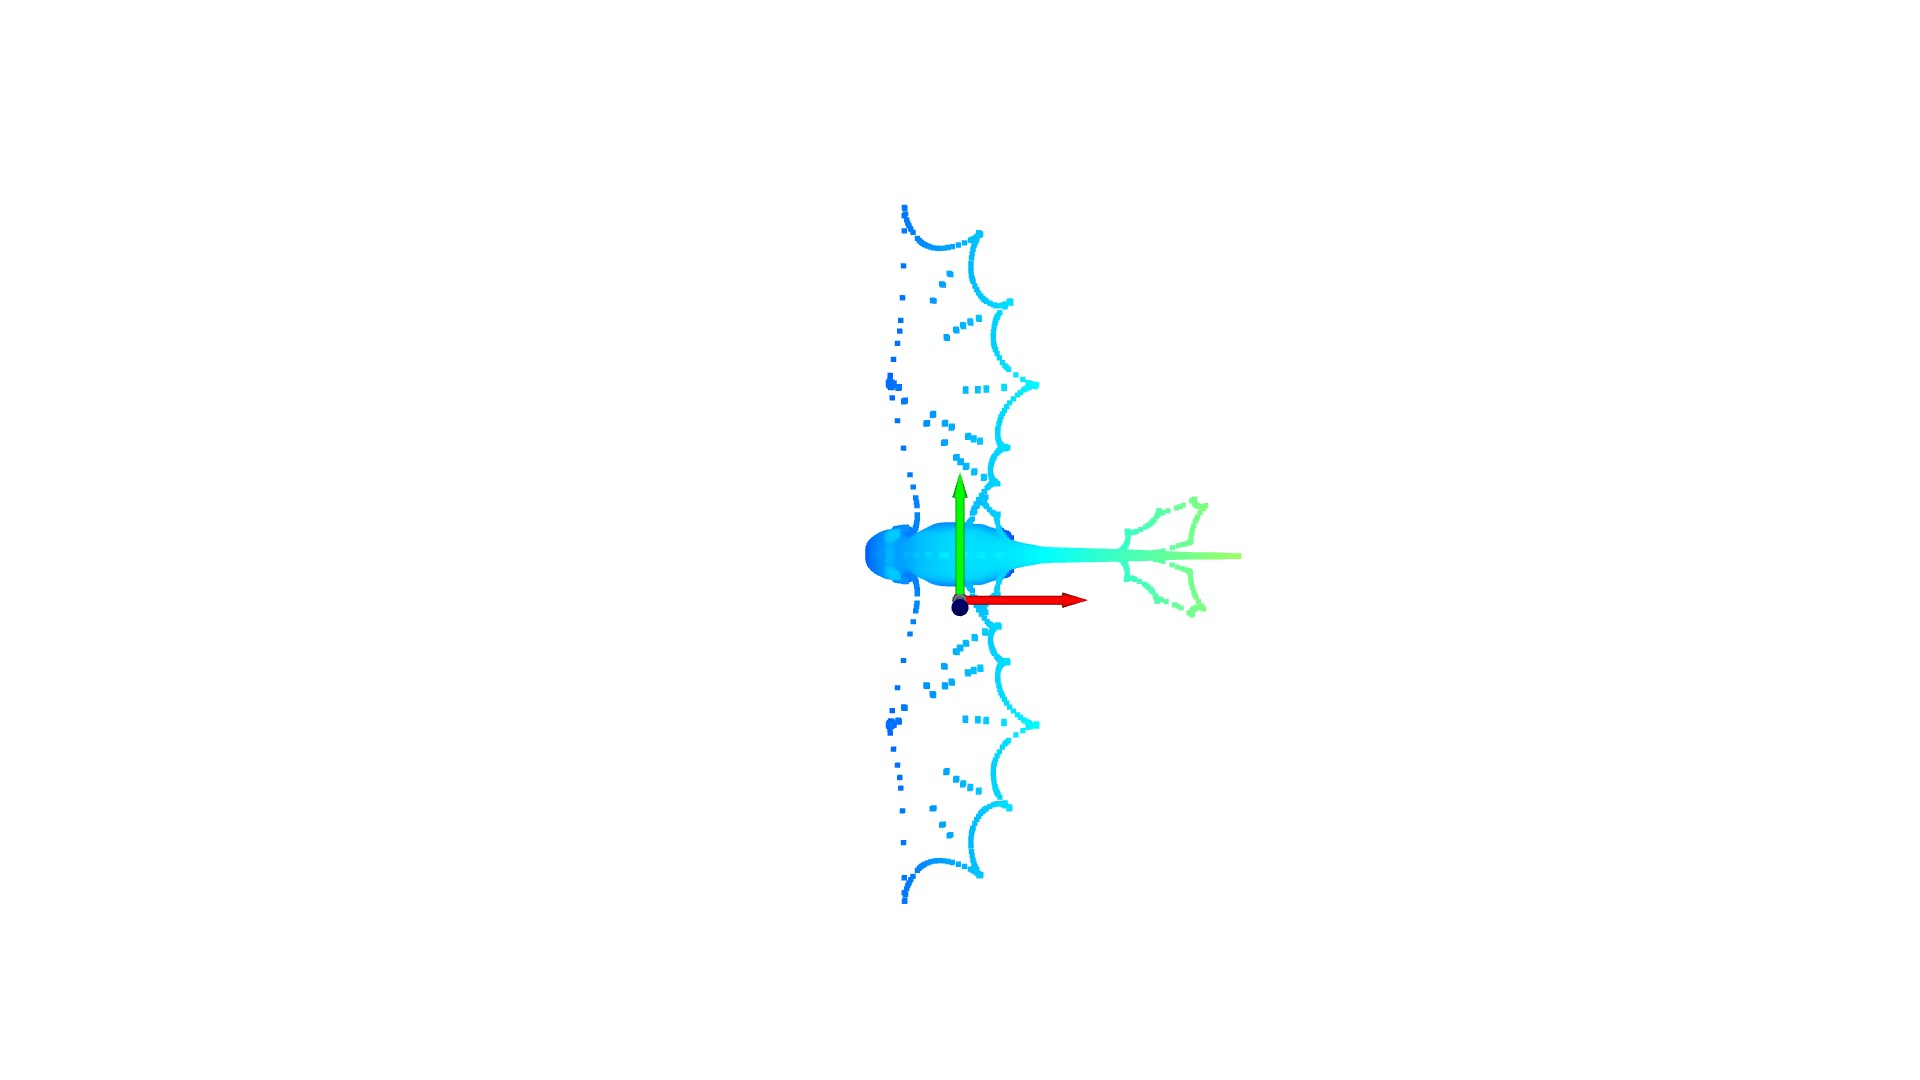

50-90-20 rotation:


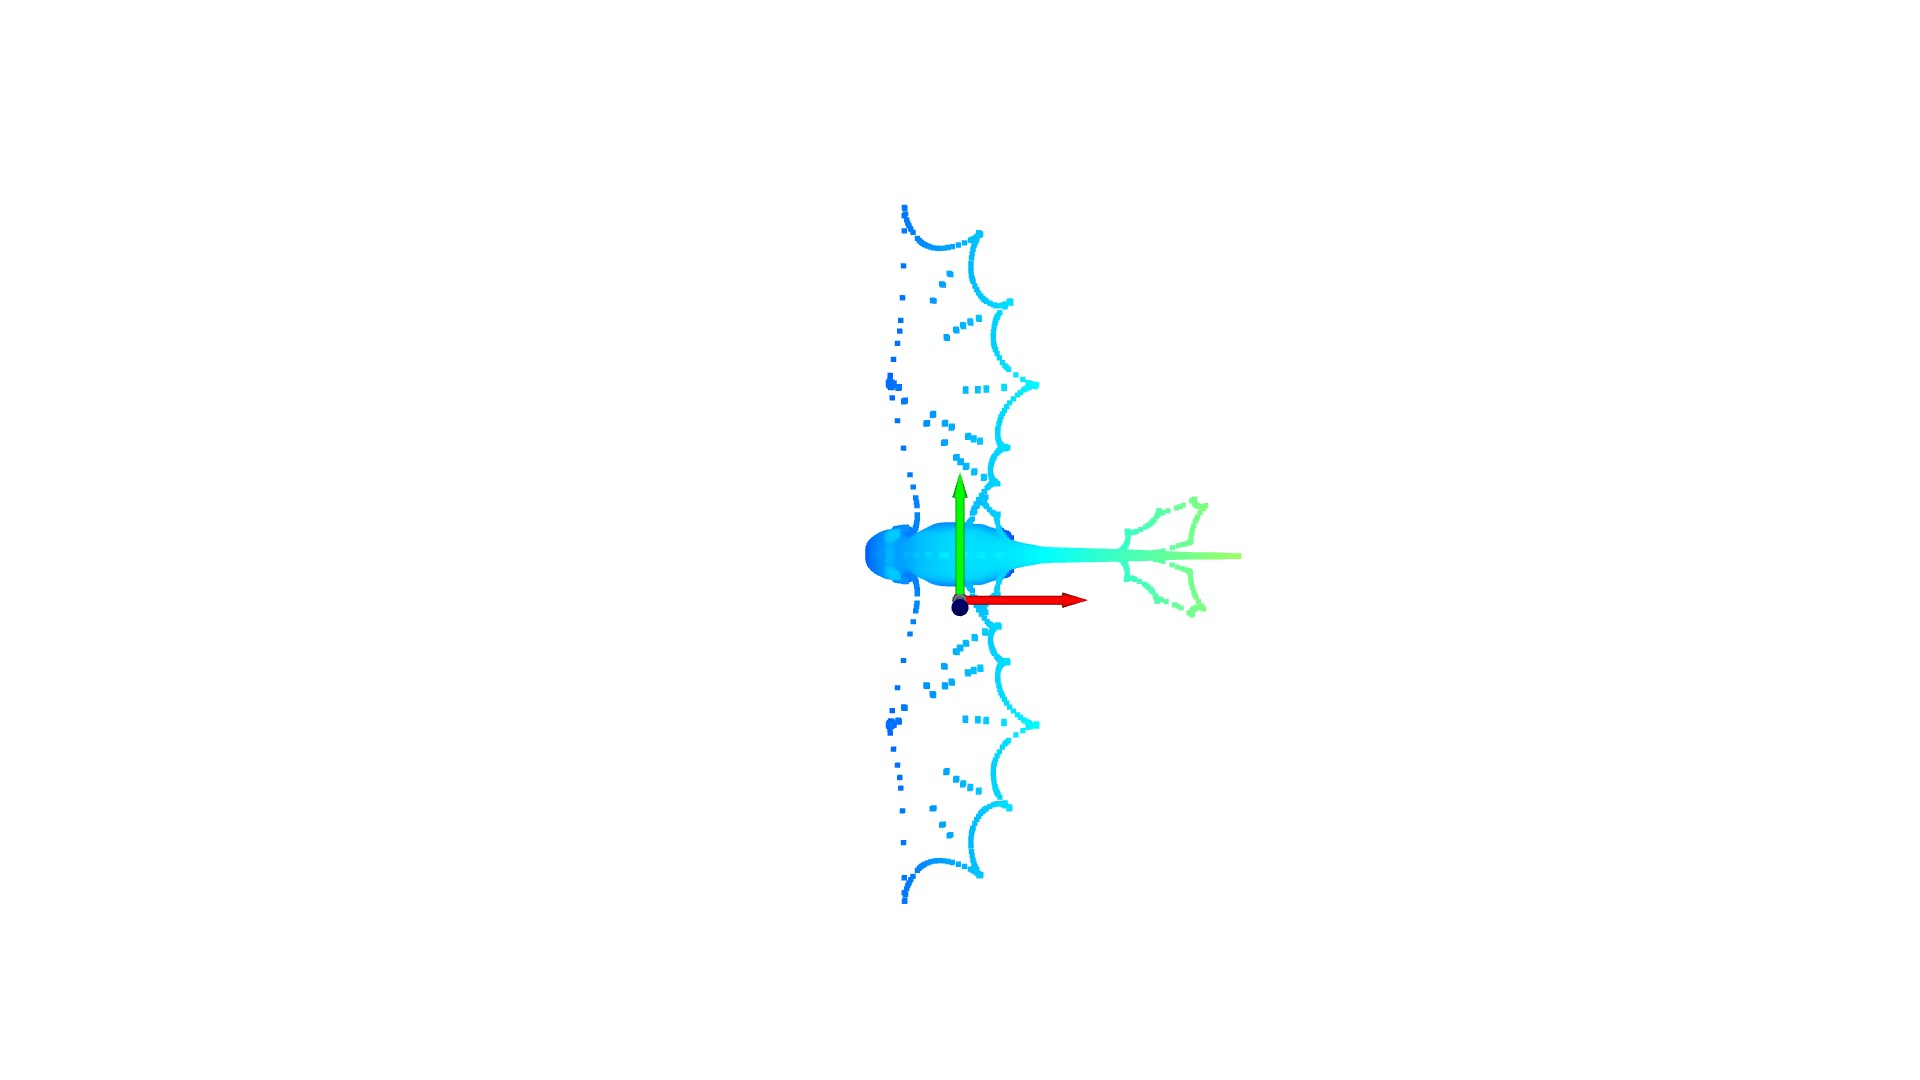

In [6]:
# showing that Case 1 and Case 2 are equivalent - using visualization made above
print("The final outputs obtained by the visualization are as follows:\n")
print("20-90-50 rotation:")
img = "./20-90-50-gimbal-end.jpg"
display(Image(img))
print("50-90-20 rotation:")
img = "./50-90-20-gimbal-end.jpg"
display(Image(img))

##############################################################################
# END OF YOUR CODE
##############################################################################

#### 1.2: Quaternions


a. Convert a rotation matrix to quaternion and vice versa. Do not use inbuilt libraries for this question.

b. Perform matrix multiplication of two 3×3 rotation matrices and perform the same transformation in the quaternion space. Verify if the final transformation obtained in both cases is the same.

c. Try to interpolate any given model between two rotation matrices and visualize!

In [4]:
##############################################################################
# TODO: Do tasks described in 1.2 (a)
##############################################################################

def convertToQuaternions(R):
    '''Finds quaternions for provided rotation matrix.
        Returns the found quaternions as a list [xi, yj, zk, w].'''
    
    e4 = 0.5 * np.sqrt(1 + R[0][0] + R[1][1] + R[2][2])
    e1 = (R[2][1] - R[1][2]) / (4 * e4)
    e2 = (R[0][2] - R[2][0]) / (4 * e4)
    e3 = (R[1][0] - R[0][1]) / (4 * e4)
    
    Q = [e1, e2, e3, e4]

    return Q

def convertToEuler(Q):
    '''Takes quaternians represented as a list [xi, yj, zk, w].
        Returns the rotation matrix representing these quaternions.'''

    e1, e2, e3, e4 = Q

    r11 = 1 - 2*(e2**2) - 2*(e3**2)
    r12 = 2 * (e1*e2 - e3*e4)
    r13 = 2 * (e1*e3 + e2*e4)
    r21 = 2 * (e1*e2 + e3*e4)
    r22 = 1 - 2*(e1**2) - 2*(e3**2)
    r23 = 2 * (e2*e3 - e1*e4)
    r31 = 2 * (e1*e3 - e2*e4)
    r32 = 2 * (e2*e3 + e1*e4)
    r33 = 1 - 2*(e1**2) - 2*(e2**2)

    R = np.array([
        [r11, r12, r13],
        [r21, r22, r33],
        [r31, r32, r33]
    ])

    return R

angles = (np.pi/6, 7 * np.pi/18, 2 * np.pi/9)

rot_matrix = findXYZRotationMatrix(angles)
quaternions = convertToQuaternions(rot_matrix)

add = 0
for i in quaternions:
    add += i**2

final_rot_mtx = convertToEuler(quaternions)

print("For values of Euler angles as follows: \n", angles)
print("\nWe have an initial rotation matrix as follows:\n")
print(rot_matrix)
print("\nWhen this rotation matrix is converted to quaternions, we get:")
print(quaternions)
print("\nThe sum of the quaternions evaluates to: ", add)
print("This verifies that the quaternion values found are correct.\n")
print("When the found quaternions are converted to a rotation matrix, we get:\n")
print(final_rot_mtx)
print("\nSince this is the same as the initial rotation matrix, it verifies our conversion.")

##############################################################################
# END OF YOUR CODE
##############################################################################

For values of Euler angles as follows: 
 (0.5235987755982988, 1.2217304763960306, 0.6981317007977318)

We have an initial rotation matrix as follows:

[[ 0.26200263 -0.21984631  0.93969262]
 [ 0.91659355  0.36140256 -0.17101007]
 [-0.30201139  0.90612129  0.29619813]]

When this rotation matrix is converted to quaternions, we get:
[0.38871645710979025, 0.4481076317236749, 0.41011978162032964, 0.6927487503321136]

The sum of the quaternions evaluates to:  1.0
This verifies that the quaternion values found are correct.

When the found quaternions are converted to a rotation matrix, we get:

[[ 0.26200263 -0.21984631  0.93969262]
 [ 0.91659355  0.36140256  0.29619813]
 [-0.30201139  0.90612129  0.29619813]]

Since this is the same as the initial rotation matrix, it verifies our conversion.


In [11]:
##############################################################################
# TODO: Do tasks described in 1.2 (b)
##############################################################################

def quaternionMul(p, q):
    '''Take 2 quaternions in the form [xi, yj, zk, w].
        Returns the multiplication of these quaternions in the same form.'''

    q1, q2, q3, q4 = q
    p1, p2, p3, p4 = p

    e1 = p4*q1 + q4*p1 + p2*q3 - p3*q2
    e2 = p4*q2 + q4*p2 + p3*q1 - p1*q3
    e3 = p4*q3 + q4*p3 + p1*q2 - p2*q1
    e4 = p4*q4 - p1*q1 - p2*q2 - p3*q3

    return [e1, e2, e3, e4]

angles1 = (1, 2, 3)
angles2 = (0.5, 1, 0.2)

R1 = findXYZRotationMatrix(angles1)
R2 = findXYZRotationMatrix(angles2)

finalR = np.matmul(R1, R2)

Q1 = convertToQuaternions(R1)
Q2 = convertToQuaternions(R2)

finalQ = quaternionMul(Q1, Q2)
finalRQ = convertToEuler(finalQ)

print("Rotation matrix 1 is obtained for 1-2-3 (in radians) transformation and rotation matrix 2 is obtained for 0.5-1-0.2 (in radians) transformation.")
print("On multiplying the 2 matrices, we get the final matrix as:\n")
print(finalR)
print("\nWhen the quaternions for the same rotation matrices are multiplied the following quaternion is obtained:")
print(finalQ)
print("\nWhen this quaternion is converted to a rotation matrix, we get:\n")
print(finalRQ)
print("\nHence, the multiplications give the same result in both the cases.\n")

##############################################################################
# END OF YOUR CODE
##############################################################################

Rotation matrix 1 is obtained for 1-2-3 (in radians) transformation and rotation matrix 2 is obtained for 0.5-1-0.2 (in radians) transformation.
On multiplying the 2 matrices, we get the final matrix as:

[[-0.31987093  0.56223367  0.76261123]
 [-0.94708668 -0.21236704 -0.24068043]
 [ 0.02663485 -0.7992456   0.60041407]]

When the quaternions for the same rotation matrices are multiplied the following quaternion is obtained:
[-0.2702230770516868, 0.3560511984790071, -0.7301801221600523, 0.5167630229541507]

When this quaternion is converted to a rotation matrix, we get:

[[-0.31987093  0.56223367  0.76261123]
 [-0.94708668 -0.21236704  0.60041407]
 [ 0.02663485 -0.7992456   0.60041407]]

Hence, the multiplications give the same result in both the cases.



In [12]:
##############################################################################
# TODO: Do tasks described in 1.2 (c)
##############################################################################

def findIntermediateRots(Ri, Rf, N=10):
    """Finds intermediate quaternions from an initial to final
        quaternion rotation pose."""
    
    interpolated_rotations = []

    # Interpolate between the quaternions
    for t in np.linspace(0, 1, N):
        R_interp = (1 - t) * Ri + t * Rf
        interpolated_rotations.append(R_interp)

    return interpolated_rotations

In [13]:
# initialising
ply_point_cloud = "./data/toothless.ply"
pcd = o3d.io.read_point_cloud(ply_point_cloud)
ref_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100, origin=[0,0,0])
pcd_copy = o3d.io.read_point_cloud(ply_point_cloud)
pcd_main = o3d.io.read_point_cloud(ply_point_cloud)

pcd.paint_uniform_color([0.7, 0.3, 0.1])
pcd_copy.paint_uniform_color([0.4, 0.2, 0.2])
pcd_main.paint_uniform_color([0.2, 0.5, 0.8])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(ref_frame)
vis.add_geometry(pcd_copy)
vis.add_geometry(pcd_main)

angles = (np.radians(40), np.radians(50), np.radians(80))
rotation_matrix = findXYZRotationMatrix(angles)
pcd_copy.rotate(rotation_matrix)

vis.update_geometry(pcd)
vis.poll_events()
vis.update_renderer()

interp_rots = findIntermediateRots(findXYZRotationMatrix((0, 0, 0)), rotation_matrix)

for i in interp_rots:
    pcd_main.rotate(i)

    vis.update_geometry(pcd_main)
    vis.poll_events()
    vis.update_renderer()

    time.sleep(0.2)

vis.run()
vis.destroy_window()

##############################################################################
# END OF YOUR CODE
##############################################################################

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


### SECTION 2: 3D Mapping from RGB-D Data

For this question, read the documentation of [Open3D](http://www.open3d.org/docs/release/) and [AI2Thor](https://github.com/allenai/ai2thor). Find the scene assigned to you in the linked [sheet](https://docs.google.com/spreadsheets/d/1dxOndEURQky4Tp-qvxR8E1Z5gPkF6RYVifHqO5eoN7s/edit#gid=0). 

2.1 Set up AI2Thor and open the scene assigned to you. Get familiar with the controller and how to change FOV, camera height, enable depth images, and move around the scene.

2.2 Write a script to record the current pose, camera, and depth images after every movement (use WASD or arrow keys for movement) - current pose should be in the AI2Thor frame and at the ground level - pose format (x, y, z, q0, q1, q2, q3). You can store any additional data, if needed, in a separate file.

2.3 Create a point cloud using Open3D for every pair of RGBD images - project the depth image to the 3D point cloud and assign a color to the points from the RGB images and make a point cloud using these points. Write your own functions for the projection and color assignment.

2.4 Transform the point clouds to their camera frame (Figure out the transformations between the camera and pose frames) - use the function from Q1 to get the rotation matrices. The frames may not be in the same hand-system.

2.5 Join all the point clouds to make a combined point cloud of the environment - also, visualize the point cloud stitching and the camera frame movement (i.e., trajectory)

2.6 Create occupancy grid maps of the environment from different heights.

## Scene 317

In [5]:
def get_ai2thor_camera_matrix(h, w, fov):
    cam_mat = np.eye(3)
    cam_mat[0, 0] = cam_mat[1, 1] = w / (2.0 * np.tan(np.deg2rad(fov / 2)))
    cam_mat[0, 2] = w / 2.0
    cam_mat[1, 2] = h / 2.0
    return cam_mat

In [6]:
##############################################################################
# TODO: Do tasks described in 2.1
##############################################################################

time_lag = 0.5

controller = Controller(
    agentMode="default",
    visibilityDistance=1.5,
    scene="FloorPlan317",

    # step sizes
    gridSize=0.25,
    snapToGrid=True,
    rotateStepDegrees=90,

    # image modalities
    renderDepthImage=False,
    renderInstanceSegmentation=True,

    # camera properties
    width=300,
    height=300,
    fieldOfView=90
)

controller.step("PausePhysicsAutoSim")
controller.step(
    action="AdvancePhysicsStep",
    timeStep=time_lag
)

# changing camera height and width
controller.reset(height=500, width=500)
# enabling depth image
controller.reset(renderDepthImage=True)
# changing field of view
controller.reset(fieldOfView=100)

controller.fieldOfView = 100

# moving around
controller.step(
    action="RotateRight",
    degrees=45
)
time.sleep(time_lag)

controller.step(action="MoveBack")
time.sleep(time_lag)

controller.step(
    action="LookDown",
    degrees=30
)
time.sleep(time_lag)

# teleporting to a random location
positions = controller.step(
    action="GetReachablePositions"
).metadata["actionReturn"]
position = random.choice(positions)
controller.step(
    action="Teleport",
    position=position
)
time.sleep(time_lag)

controller.step(action="Done")

time.sleep(2)

##############################################################################
# END OF YOUR CODE
##############################################################################

In [7]:
##############################################################################
# TODO: Do tasks described in 2.2
##############################################################################

os.makedirs("output", exist_ok=True)

no_moves = 0
move = input("Enter W/A/S/D to move or Q to quit: ").upper()
while move != "Q":
    if move == "W":
        event = controller.step(action="MoveAhead")
    elif move == "A":
        event = controller.step(action="MoveLeft")
    elif move == "S":
        event = controller.step(action="MoveBack")
    elif move == "D":
        event = controller.step(action="MoveRight")
    else:
        print("Enter valid input - W/A/S/D/Q")
        move = input("Enter W/A/S/D to move or Q to quit: ").upper()
        continue

    event = controller.last_event
    no_moves += 1
    agent = event.metadata["agent"]
    depth_image = np.array(event.depth_frame)
    camera_image = np.array(event.frame)
    pos = agent['position']
    rot = agent['rotation']
    rot_quat = convertToQuaternions(findXYZRotationMatrix((rot['x'], rot['y'], rot['z'])))
    position = [pos['x'], pos['y'], pos['z'], rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]

    np.save(f'./output/pose{no_moves}', position)
    np.save(f'./output/camera_image{no_moves}', camera_image)
    np.save(f'./output/depth_image{no_moves}', depth_image)

    move = input("Enter W/A/S/D to move or Q to quit: ").upper()

    # print(depth_image)
    # print(camera_image)
    # print(position)

##############################################################################
# END OF YOUR CODE
##############################################################################

Enter W/A/S/D to move or Q to quit:  W
Enter W/A/S/D to move or Q to quit:  Q


In [8]:
##############################################################################
# TODO: Do tasks described in 2.3
##############################################################################

h = controller.height
w = controller.width
fov = controller.fieldOfView
cam_calibration = get_ai2thor_camera_matrix(h, w, fov)

pcds = []
for i in range(1, no_moves+1):
    camera_image = np.load(f'./output/camera_image{i}.npy', allow_pickle = True)
    depth_image =np.load(f'./output/depth_image{i}.npy', allow_pickle = True)

    points = []
    colors = []

    for y in range(len(depth_image)):
        for x in range(len(depth_image[y])):
            if(depth_image[y][x] < 10):
                coord = np.transpose(np.array([x, y, 1]))
                calc_points = depth_image[y][x] * (np.matmul(np.linalg.inv(cam_calibration), coord))
                points.append(np.transpose(calc_points))
                colors.append(camera_image[y][x]/255)
    
    points_fin = np.array(points)
    colors_fin = np.array(colors)
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcds.append(pcd)
    
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    
    vis.run() 
    vis.destroy_window()

##############################################################################
# END OF YOUR CODE
##############################################################################

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [9]:
##############################################################################
# TODO: Do tasks described in 2.4
##############################################################################

camera_poses = []

for step in range(no_moves):
    position = np.load(f'./output/pose{step+1}.npy', allow_pickle = True)
    q = [position[4], position[5], position[6], position[3]]
    R = convertToEuler(q)
    T = np.array([position[0], position[1], position[2]])
    camera_poses.append((R, T))

    pcd = pcds[step]

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    pcd.rotate(R)
    pcd.translate(T)

    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    vis.run() 
    vis.destroy_window()

##############################################################################
# END OF YOUR CODE
##############################################################################

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [10]:
##############################################################################
# TODO: Do tasks described in 2.5
##############################################################################

# combined_pcdx = pcds[0]
# cpmbined_pcd = pcds[0]
# for pcd in pcds[1:]:
#     combined_pcd = combined_pcdx + pcd
#     combined_pcdx = combined_pcd

# camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
# combined_pcd = combined_pcdx
# o3d.visualization.draw_geometries(combined_pcd)

vis = o3d.visualization.Visualizer()
vis.create_window()
# vis.add_geometry(combined_pcd)

for pcd in pcds:
    vis.add_geometry(pcd)

camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
for pose in camera_poses:
    camera_frame.translate(pose[1])
    camera_frame.rotate(pose[0])
    vis.add_geometry(camera_frame)
    vis.run()
    vis.destroy_window()

##############################################################################
# END OF YOUR CODE
##############################################################################

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


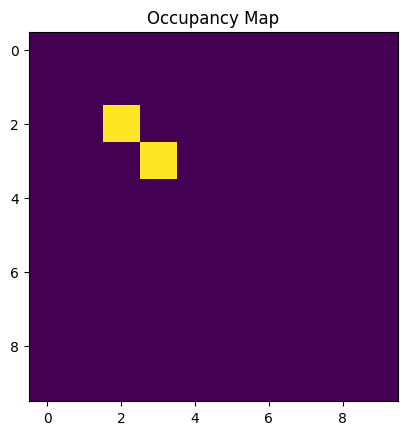

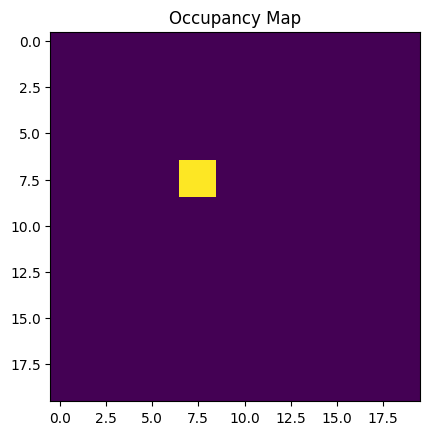

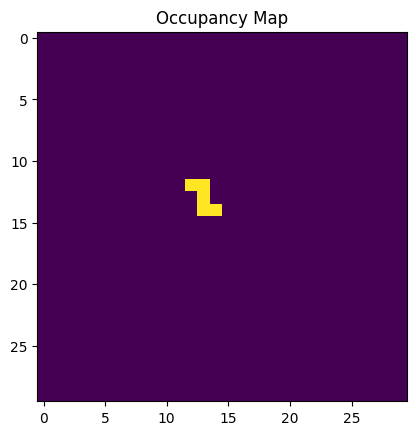

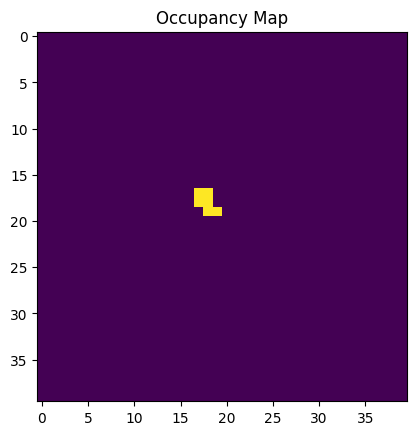

In [36]:
##############################################################################
# TODO: Do tasks described in 2.6
##############################################################################

heights = [10, 20, 30, 40]

for height in heights:
    event = controller.reset(height=height, width=height)
    event = controller.last_event

    map_width, map_height = controller.width, controller.height
    occupancy_map = np.zeros((map_height, map_width), dtype=np.uint8)
    
    depth_image = np.array(event.depth_frame)
    camera_image = np.array(event.frame)

    # print(map_width, map_height)

    for y in range(len(depth_image)):
        for x in range(len(depth_image[y])):
            if(depth_image[y][x] < 10):
                arr = np.array([x, y, 1])
                coord = np.transpose(arr)
                calc_points = depth_image[y][x] * (np.matmul(np.linalg.inv(cam_calibration), coord))
                x1 = int(np.round(calc_points[0]+map_height/2))
                y1 = int(np.round(calc_points[1]+map_width/2))
                # print(x1, y1)
                # print(calc_points)
                occupancy_map[y1, x1] = 1

    plt.imshow(occupancy_map, origin='upper')
    plt.title("Occupancy Map")
    plt.show()

##############################################################################
# END OF YOUR CODE
##############################################################################